In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [14]:
file_path = '../Features/Large/selected_features_CorrVar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,RingCount,MolLogP,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_ether,fr_halogen
0,0,0.545511,0.223433,0.490223,0.390551,0.291325,0.250000,0.472316,0.592036,-1.017995,...,0.447214,0.451534,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
1,1,0.591920,0.253125,0.601726,0.389406,0.277681,0.278846,0.315886,0.215424,1.052267,...,0.447214,0.416318,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
2,1,0.553126,0.334919,0.502072,0.400859,0.399452,0.278846,0.472195,0.592036,-1.018511,...,0.447214,0.475805,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
3,0,0.612445,0.602032,0.496240,0.408749,0.461148,0.423077,0.676377,0.290413,0.491735,...,0.000000,0.560347,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
4,0,0.618170,0.914475,0.141109,0.000000,0.000000,0.000000,0.354992,0.378416,-0.071536,...,0.000000,0.225586,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [15]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [22]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 1989 samples
Test set: 498 samples


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 Irritation
1    0.515334
0    0.484666
Name: proportion, dtype: float64
Test class distribution:
 Irritation
1    0.516064
0    0.483936
Name: proportion, dtype: float64


In [25]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 10, 50),  # Avoid very low values
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2),
    }
    
    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores = []
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = KNeighborsClassifier(**param)
        model.fit(X_train_cv, y_train_cv)
        
        # Compute accuracy
        train_acc = accuracy_score(y_train_cv, model.predict(X_train_cv))
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        
        train_scores.append(train_acc)
        valid_scores.append(valid_acc)

    # Compute mean scores
    mean_train_acc = sum(train_scores) / len(train_scores)
    mean_valid_acc = sum(valid_scores) / len(valid_scores)
    
    # Penalize overfitting: Reward high validation accuracy & penalize large train-valid difference
    overfit_penalty = abs(mean_train_acc - mean_valid_acc)  # Gap between train & valid
    objective_score = mean_valid_acc - (overfit_penalty * 0.5)  # Reduce score if overfitting
    
    return objective_score

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-03-09 15:12:38,960] A new study created in memory with name: no-name-eee2490c-2a41-41ae-8763-8ad7005dfa91
[I 2025-03-09 15:12:39,338] Trial 0 finished with value: 0.6619365301612832 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.6619365301612832.
[I 2025-03-09 15:12:40,076] Trial 1 finished with value: 0.6763176108175224 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.6763176108175224.
[I 2025-03-09 15:12:40,783] Trial 2 finished with value: 0.6878111248995605 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.6878111248995605.
[I 2025-03-09 15:12:41,306] Trial 3 finished with value: 0.5550219611913474 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.6878111248995605.
[I 2025-03-09 15:12:41,981] Trial 4 finished with value: 0.6861881701967845 and parameters: {'n_neighbors': 27, 'weights'

Best trial: {'n_neighbors': 24, 'weights': 'uniform', 'p': 1}
Final Model Accuracy: 0.7269076305220884


Final Model Accuracy on Test: 0.7269076305220884


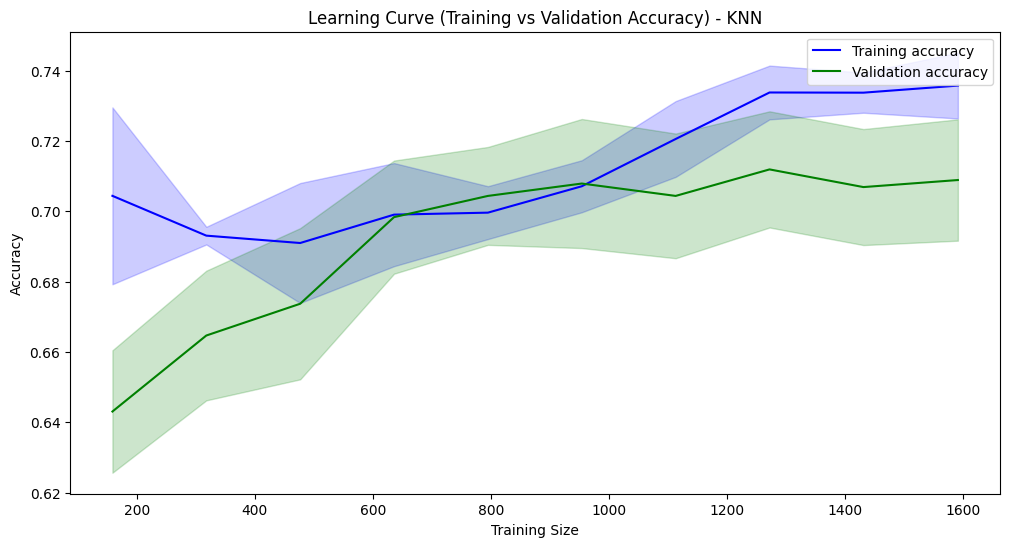

Train Accuracy: 0.7445952740070387
Test Accuracy: 0.7269076305220884


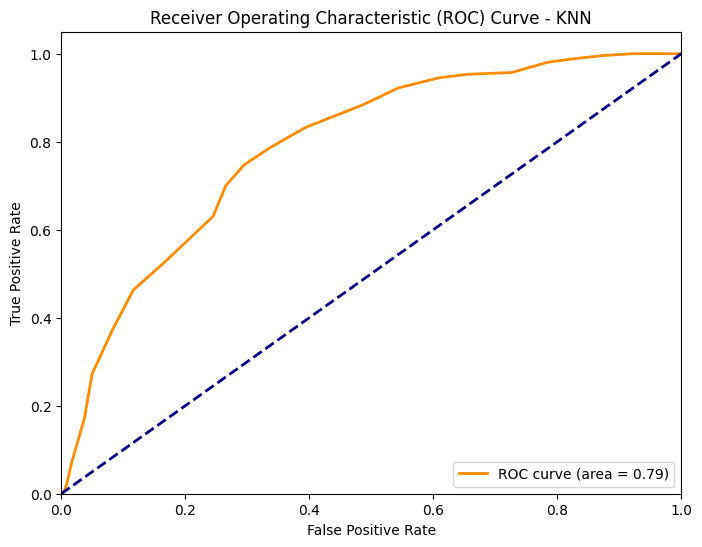

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

# Get best hyperparameters from study
best_params = study.best_trial.params

# Initialize the KNN model with best parameters
final_model = KNeighborsClassifier(**best_params)

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Evaluate final model on test data
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy) - KNN')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# ROC Curve
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc='lower right')
plt.show()


In [10]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 353 samples
Test set: 89 samples


Best k based on test accuracy: 6
Best Training Accuracy: 0.7944
Best Testing Accuracy: 0.7309
Best k based on bias-variance tradeoff: 36


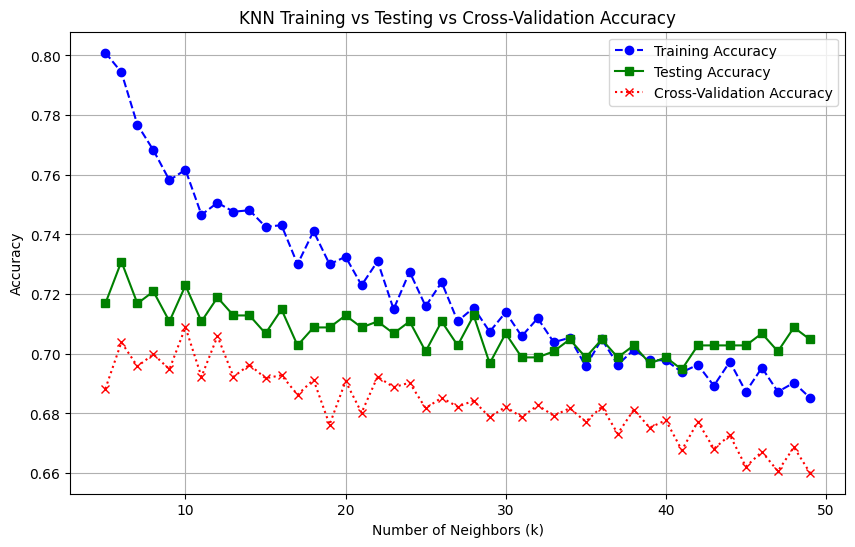

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Define range of k values
k_values = range(5, 50)
train_accuracies = []
test_accuracies = []
cv_accuracies = []

# Iterate over different k values
best_k = 1
best_test_acc = 0
best_train_acc = 0
best_tradeoff_k = 1
best_tradeoff_value = float('inf')

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)  # Train the model
    
    # Compute training and test accuracy
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Perform cross-validation (5-fold)
    cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    cv_accuracies.append(cv_acc)
    
    # Track best k based on test accuracy
    if test_acc > best_test_acc:
        best_k = k
        best_test_acc = test_acc
        best_train_acc = train_acc
    
    # Find the best tradeoff between bias and variance
    tradeoff_value = abs(train_acc - test_acc)
    if tradeoff_value < best_tradeoff_value:
        best_tradeoff_value = tradeoff_value
        best_tradeoff_k = k

# Print best k and corresponding accuracy
print(f"Best k based on test accuracy: {best_k}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Testing Accuracy: {best_test_acc:.4f}")
print(f"Best k based on bias-variance tradeoff: {best_tradeoff_k}")

# Plot training vs testing vs cross-validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o', linestyle='dashed', color='blue')
plt.plot(k_values, test_accuracies, label='Testing Accuracy', marker='s', linestyle='solid', color='green')
plt.plot(k_values, cv_accuracies, label='Cross-Validation Accuracy', marker='x', linestyle='dotted', color='red')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Training vs Testing vs Cross-Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [11]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'knn_model.pkl')

print("Model saved successfully!")


Model saved successfully!
